# Code for Fig. 2 and fig. S2 of
#### Yeager et al., 2021: An Outsized Role for the Labrador Sea in the Multidecadal Variability of the Atlantic Overturning Circulation, *Science Advances*.

In [1]:
import xarray as xr               #netcdf multidim reading/writing/manipulation
import cftime
import numpy as np                #numerics
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
from scipy import signal
import os                         #operating system commands
import subprocess
import sys
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def open_POPdataset(x):
    ds = xr.open_dataset(x,decode_times=False)
    attrs=ds.time.attrs.copy()
    ds = ds.assign_coords(time=ds.time.values - 15)
    ds.time.attrs = attrs
    ds = xr.decode_cf(ds)
    return ds

In [3]:
datadir = '/glade/scratch/yeager/YeagerEA_ScienceAdvances_2021/'
f1_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.015001_050012.MOCsig.osnap.nc'
f1_lr = f'{datadir}/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.000101_050012.MOCsig.osnap.nc'

ds1_hr = open_POPdataset(f1_hr) 
ds1_lr = open_POPdataset(f1_lr)
ds1_hr_ann_mean = ds1_hr.groupby('time.year').mean('time')
ds1_hr_ann_mean=ds1_hr_ann_mean.rename({'year':'time'})
ds1_lr_ann_mean = ds1_lr.groupby('time.year').mean('time')
ds1_lr_ann_mean=ds1_lr_ann_mean.rename({'year':'time'})
ds1_hr_21mon_mean = ds1_hr.rolling(time=21,center=True).mean().dropna("time")
ds1_lr_21mon_mean = ds1_lr.rolling(time=21,center=True).mean().dropna("time")
ds1_hr_21mon_std = ds1_hr.rolling(time=21,center=True).std().dropna("time")
ds1_lr_21mon_std = ds1_lr.rolling(time=21,center=True).std().dropna("time")

In [4]:
# OSNAP Data
# Downloaded from:  https://www.o-snap.org/
ds_os3 = xr.open_dataset(f'{datadir}/OSNAP_Streamfunction_201408_201604_2018.nc',use_cftime=True)

###  Fig. 2

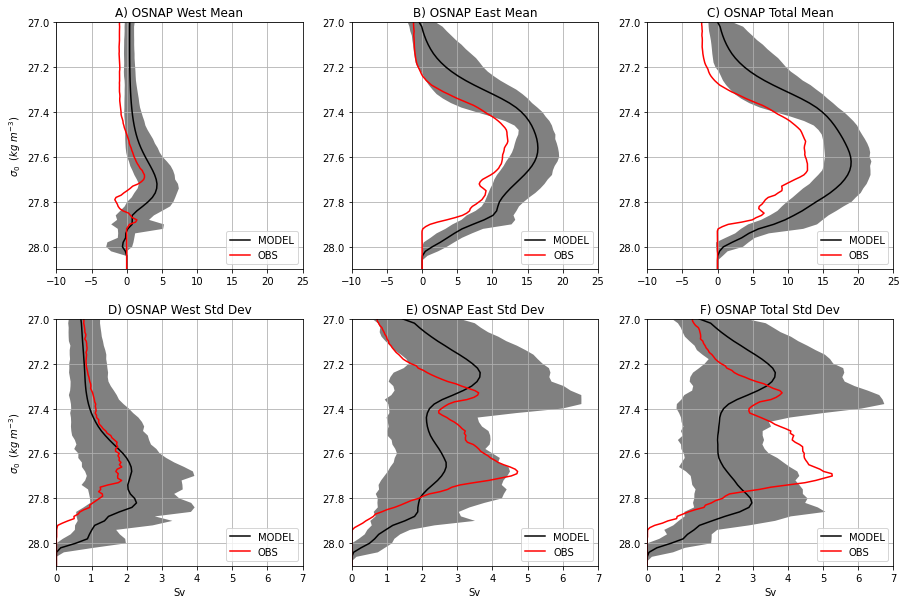

In [5]:
# MOC profile plots w/ OSNAP
# Get OSNAP profiles
# NOTE:  Need OSNAP time axis in cftime.DateTimeNoLeap in order to plot with POP output!
dir_osnap = '/glade/p/cgd/oce/people/yeager/obs/OSNAP/data/files'
ds_os3 = xr.open_dataset(f'{dir_osnap}/OSNAP_Streamfunction_201408_201604_2018.nc',use_cftime=True)
osntot_mean = ds_os3.T_ALL.mean('TIME')
osntot_std = ds_os3.T_ALL.std('TIME')
osnw_mean = ds_os3.T_WEST.mean('TIME')
osnw_std = ds_os3.T_WEST.std('TIME')
osne_mean = ds_os3.T_EAST.mean('TIME')
osne_std = ds_os3.T_EAST.std('TIME')

#work1 = ds1_lr_21mon_mean.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
#work2 = ds1_lr_21mon_std.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
#simstr = 'LR'
work1 = ds1_hr_21mon_mean.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
work2 = ds1_hr_21mon_std.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
work1a = ds1_hr_21mon_mean.MOCsig0.sel(time=slice("0415-01-01","0420-01-01"))
work2a = ds1_hr_21mon_std.MOCsig0.sel(time=slice("0415-01-01","0420-01-01"))
simstr = 'HR'

simstr = 'MODEL'

ystr = r'${\sigma}_0 \;\; (kg \;m^{-3})$'
xstr = 'Sv'

# renormalize
osntot_mean = osntot_mean - osntot_mean[-1]
osnw_mean = osnw_mean - osnw_mean[-1]
osne_mean = osne_mean - osne_mean[-1]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ylim1 = [37.5,35.5]
ylim2 = [28.1, 27.0]
xlim = [-10,25]
xlim2 = [0,7]

# Left Panel
ax1.set_title('A) OSNAP West Mean')
mn = work1.isel(moc_comp=1).mean('time')
sd1 = work1.isel(moc_comp=1).min('time')
sd2 = work1.isel(moc_comp=1).max('time')
ax1.plot(mn,mn.moc_sig0, color='black', label=simstr)
#ax1.plot(work1a.isel(moc_comp=1).mean('time'),mn.moc_sig0, color='black', linestyle='dashed',label=simstr)
ax1.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax1.plot(osnw_mean,osnw_mean.LEVEL, color='red', label="OBS")
ax1.set_ylabel(ystr)
#ax1.set_xlabel(xstr)
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_ylim(ylim2)
ax1.set_xlim(xlim)

ax2.set_title('B) OSNAP East Mean')
mn = work1.isel(moc_comp=2).mean('time')
sd1 = work1.isel(moc_comp=2).min('time')
sd2 = work1.isel(moc_comp=2).max('time')
ax2.plot(mn,mn.moc_sig0, color='black', label=simstr)
#ax2.plot(work1a.isel(moc_comp=2).mean('time'),mn.moc_sig0, color='black', linestyle='dashed',label=simstr)
ax2.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax2.plot(osne_mean,osne_mean.LEVEL, color='red', label="OBS")
#ax2.set_xlabel(xstr)
ax2.grid(True)
ax2.legend(loc='lower right')
ax2.set_ylim(ylim2)
ax2.set_xlim(xlim)

ax3.set_title('C) OSNAP Total Mean')
mn = work1.isel(moc_comp=0).mean('time')
sd1 = work1.isel(moc_comp=0).min('time')
sd2 = work1.isel(moc_comp=0).max('time')
ax3.plot(mn,mn.moc_sig0, color='black', label=simstr)
#ax3.plot(work1a.isel(moc_comp=0).mean('time'),mn.moc_sig0, color='black', linestyle='dashed',label=simstr)
ax3.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax3.plot(osntot_mean,osntot_mean.LEVEL, color='red', label="OBS")
#ax3.set_xlabel(xstr)
ax3.grid(True)
ax3.legend(loc='lower right')
ax3.set_ylim(ylim2)
ax3.set_xlim(xlim)

# Left Panel
ax4.set_title('D) OSNAP West Std Dev')
mn = work2.isel(moc_comp=1).mean('time')
sd1 = work2.isel(moc_comp=1).min('time')
sd2 = work2.isel(moc_comp=1).max('time')
ax4.plot(mn,mn.moc_sig0, color='black', label=simstr)
#ax4.plot(work2a.isel(moc_comp=1).mean('time'),mn.moc_sig0, color='black', linestyle='dashed',label=simstr)
ax4.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax4.plot(osnw_std,osnw_std.LEVEL, color='red', label="OBS")
ax4.set_ylabel(ystr)
ax4.set_xlabel(xstr)
ax4.grid(True)
ax4.legend(loc='lower right')
ax4.set_ylim(ylim2)
ax4.set_xlim(xlim2)

ax5.set_title('E) OSNAP East Std Dev')
mn = work2.isel(moc_comp=2).mean('time')
sd1 = work2.isel(moc_comp=2).min('time')
sd2 = work2.isel(moc_comp=2).max('time')
ax5.plot(mn,mn.moc_sig0, color='black', label=simstr)
#ax5.plot(work2a.isel(moc_comp=2).mean('time'),mn.moc_sig0, color='black', linestyle='dashed',label=simstr)
ax5.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax5.plot(osne_std,osne_std.LEVEL, color='red', label="OBS")
ax5.set_xlabel(xstr)
ax5.grid(True)
ax5.legend(loc='lower right')
ax5.set_ylim(ylim2)
ax5.set_xlim(xlim2)

ax6.set_title('F) OSNAP Total Std Dev')
mn = work2.isel(moc_comp=0).mean('time')
sd1 = work2.isel(moc_comp=0).min('time')
sd2 = work2.isel(moc_comp=0).max('time')
ax6.plot(mn,mn.moc_sig0, color='black', label=simstr)
#ax6.plot(work2a.isel(moc_comp=0).mean('time'),mn.moc_sig0, color='black', linestyle='dashed',label=simstr)
ax6.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax6.plot(osntot_std,osntot_std.LEVEL, color='red', label="OBS")
ax6.set_xlabel(xstr)
ax6.grid(True)
ax6.legend(loc='lower right')
ax6.set_ylim(ylim2)
ax6.set_xlim(xlim2)

plt.savefig('Fig_2.pdf')

###  Compare East/West Mean & Variance Ratios to Observations

In [6]:
work1 = ds1_hr_21mon_mean.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
ewratio = work1.isel(moc_comp=2).max('moc_sig0')/work1.isel(moc_comp=1).max('moc_sig0')
ewratio.mean('time').values, ewratio.min('time').values, ewratio.max('time').values

(array(3.7431242, dtype=float32), array(2.23953891), array(7.37281942))

In [7]:
obsratio = osne_mean.max('LEVEL')/osnw_mean.max('LEVEL')
osne_mean.max('LEVEL').values,osnw_mean.max('LEVEL').values,obsratio.values

(array(12.19255161), array(2.52979898), array(4.81957329))

In [8]:
# Check LSW 21-month variability ratio (Reviewer 1)
ds1_hr_lsw = ds1_hr.MOCsig0.sel(moc_sig0=slice(27.74,27.8)).mean('moc_sig0')
ds1_hr_lsw_21mon_std = ds1_hr_lsw.rolling(time=21,center=True).std().dropna("time")
work1 = ds1_hr_lsw_21mon_std.sel(time=slice("0200-01-01","0500-01-01"))
ewratio = work1.isel(moc_comp=2)/work1.isel(moc_comp=1)
ewratio.mean('time').values, ewratio.min('time').values, ewratio.max('time').values

(array(1.106437, dtype=float32), array(0.38671762), array(2.50928855))

In [9]:
osnw_lsw = ds_os3.T_WEST.sel(LEVEL=slice(27.74,27.8)).mean('LEVEL')
osne_lsw = ds_os3.T_EAST.sel(LEVEL=slice(27.74,27.8)).mean('LEVEL')
obsratio = osne_lsw.std('TIME')/osnw_lsw.std('TIME')
obsratio

<xarray.DataArray ()>
array(1.99948806)

In [10]:
# Check LSW 21-month variability ratio (Reviewer 1)
ds1_hr_lsw = ds1_hr.MOCsig0.sel(moc_sig0=slice(27.7,27.75)).mean('moc_sig0')
ds1_hr_lsw_21mon_std = ds1_hr_lsw.rolling(time=21,center=True).std().dropna("time")
work1 = ds1_hr_lsw_21mon_std.sel(time=slice("0200-01-01","0500-01-01"))
ewratio = work1.isel(moc_comp=2)/work1.isel(moc_comp=1)
ewratio.mean('time').values, ewratio.min('time').values, ewratio.max('time').values

(array(1.253983, dtype=float32), array(0.4111138), array(3.05194306))

In [11]:
osnw_lsw = ds_os3.T_WEST.sel(LEVEL=slice(27.7,27.75)).mean('LEVEL')
osne_lsw = ds_os3.T_EAST.sel(LEVEL=slice(27.7,27.75)).mean('LEVEL')
obsratio = osne_lsw.std('TIME')/osnw_lsw.std('TIME')
obsratio

<xarray.DataArray ()>
array(2.27431394)

In [25]:
# Check LSW 21-month variability ratio (Reviewer 1)
ds1_hr_lsw = ds1_hr.MOCsig0.sel(moc_sig0=27.8,method='nearest')
ds1_hr_lsw_21mon_std = ds1_hr_lsw.rolling(time=21,center=True).std().dropna("time")
work1 = ds1_hr_lsw_21mon_std.sel(time=slice("0200-01-01","0500-01-01"))
ewratio = work1.isel(moc_comp=2)/work1.isel(moc_comp=1)
ewratio.mean('time').values, ewratio.min('time').values, ewratio.max('time').values

(array(0.9051305, dtype=float32), array(0.3484962), array(2.69710898))

In [26]:
osnw_lsw = ds_os3.T_WEST.sel(LEVEL=27.75,method='nearest')
osne_lsw = ds_os3.T_EAST.sel(LEVEL=27.75,method='nearest')
obsratio = osne_lsw.std('TIME')/osnw_lsw.std('TIME')
obsratio

<xarray.DataArray ()>
array(2.28607727)
Coordinates:
    LEVEL    float32 27.75

In [32]:
osnw_std = ds_os3.T_WEST.std('TIME')
osne_std = ds_os3.T_EAST.std('TIME')
obsratio = osne_std.where(osne_std>0.1)/osnw_std.where(osnw_std>0.1)

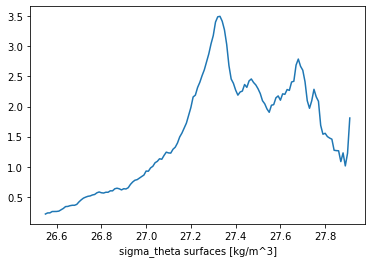

In [33]:
obsratio.plot();

(-5.0, 10.0)

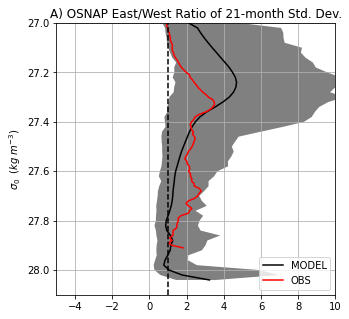

In [37]:
# MOC profile plots w/ OSNAP
# Get OSNAP profiles
# NOTE:  Need OSNAP time axis in cftime.DateTimeNoLeap in order to plot with POP output!
dir_osnap = '/glade/p/cgd/oce/people/yeager/obs/OSNAP/data/files'
ds_os3 = xr.open_dataset(f'{dir_osnap}/OSNAP_Streamfunction_201408_201604_2018.nc',use_cftime=True)

osnw_std = ds_os3.T_WEST.std('TIME')
osne_std = ds_os3.T_EAST.std('TIME')
obsratio = osne_std.where(osne_std>0.1)/osnw_std.where(osnw_std>0.1)

work2 = ds1_hr_21mon_std.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
work2e = work2.isel(moc_comp=2)
work2w = work2.isel(moc_comp=1)
modratio = work2e.where(work2e>0.1)/work2w.where(work2w>0.1)

ystr = r'${\sigma}_0 \;\; (kg \;m^{-3})$'
xstr = 'Sv'


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

ylim2 = [28.1, 27.0]
xlim = [-5,10]
xlim2 = [0,7]

# Left Panel
ax1.set_title('A) OSNAP East/West Ratio of 21-month Std. Dev.')
min1 = modratio.min('time')
max2 = modratio.max('time')
ax1.plot(modratio.mean('time'),modratio.moc_sig0, color='black', label=simstr)
ax1.fill_betweenx(modratio.moc_sig0, min1, max2, facecolor="grey")
ax1.plot(obsratio,obsratio.LEVEL, color='red', label="OBS")
ax1.plot([1,1],ylim2, color='black',linestyle='--')
ax1.set_ylabel(ystr)
#ax1.set_xlabel(xstr)
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_ylim(ylim2)
ax1.set_xlim(xlim)



###  fig. S2

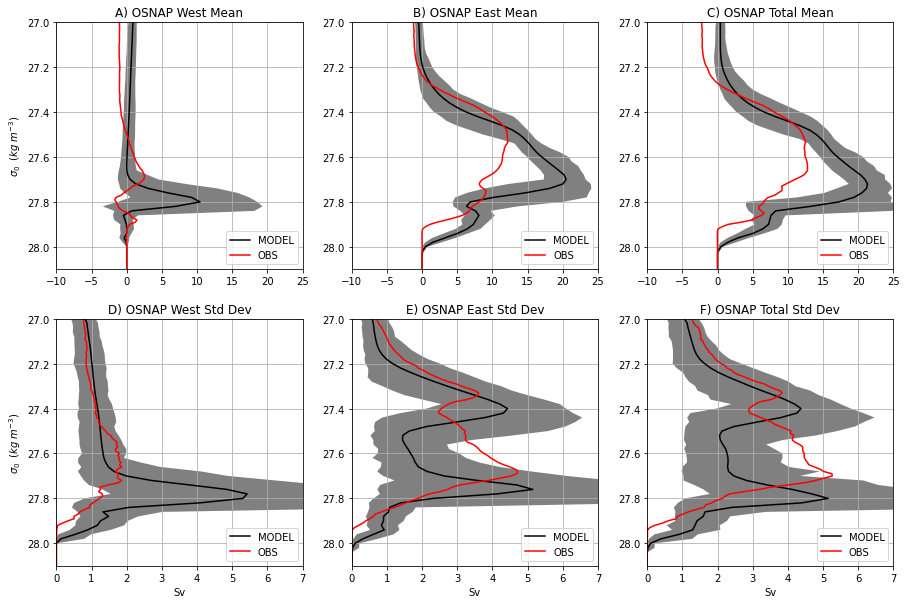

In [6]:
osntot_mean = ds_os3.T_ALL.mean('TIME')
osntot_std = ds_os3.T_ALL.std('TIME')
osnw_mean = ds_os3.T_WEST.mean('TIME')
osnw_std = ds_os3.T_WEST.std('TIME')
osne_mean = ds_os3.T_EAST.mean('TIME')
osne_std = ds_os3.T_EAST.std('TIME')

work1 = ds1_lr_21mon_mean.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
work2 = ds1_lr_21mon_std.MOCsig0.sel(time=slice("0200-01-01","0500-01-01"))
simstr = 'LR'
simstr = 'MODEL'
ystr = r'${\sigma}_0 \;\; (kg \;m^{-3})$'
xstr = 'Sv'

# renormalize
osntot_mean = osntot_mean - osntot_mean[-1]
osnw_mean = osnw_mean - osnw_mean[-1]
osne_mean = osne_mean - osne_mean[-1]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ylim1 = [37.5,35.5]
ylim2 = [28.1, 27.0]
xlim = [-10,25]
xlim2 = [0,7]

# Left Panel
ax1.set_title('A) OSNAP West Mean')
mn = work1.isel(moc_comp=1).mean('time')
sd1 = work1.isel(moc_comp=1).min('time')
sd2 = work1.isel(moc_comp=1).max('time')
ax1.plot(mn,mn.moc_sig0, color='black', label=simstr)
ax1.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax1.plot(osnw_mean,osnw_mean.LEVEL, color='red', label="OBS")
ax1.set_ylabel(ystr)
#ax1.set_xlabel(xstr)
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_ylim(ylim2)
ax1.set_xlim(xlim)

ax2.set_title('B) OSNAP East Mean')
mn = work1.isel(moc_comp=2).mean('time')
sd1 = work1.isel(moc_comp=2).min('time')
sd2 = work1.isel(moc_comp=2).max('time')
ax2.plot(mn,mn.moc_sig0, color='black', label=simstr)
ax2.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax2.plot(osne_mean,osne_mean.LEVEL, color='red', label="OBS")
#ax2.set_xlabel(xstr)
ax2.grid(True)
ax2.legend(loc='lower right')
ax2.set_ylim(ylim2)
ax2.set_xlim(xlim)

ax3.set_title('C) OSNAP Total Mean')
mn = work1.isel(moc_comp=0).mean('time')
sd1 = work1.isel(moc_comp=0).min('time')
sd2 = work1.isel(moc_comp=0).max('time')
ax3.plot(mn,mn.moc_sig0, color='black', label=simstr)
ax3.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax3.plot(osntot_mean,osntot_mean.LEVEL, color='red', label="OBS")
#ax3.set_xlabel(xstr)
ax3.grid(True)
ax3.legend(loc='lower right')
ax3.set_ylim(ylim2)
ax3.set_xlim(xlim)

# Left Panel
ax4.set_title('D) OSNAP West Std Dev')
mn = work2.isel(moc_comp=1).mean('time')
sd1 = work2.isel(moc_comp=1).min('time')
sd2 = work2.isel(moc_comp=1).max('time')
ax4.plot(mn,mn.moc_sig0, color='black', label=simstr)
ax4.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax4.plot(osnw_std,osnw_std.LEVEL, color='red', label="OBS")
ax4.set_ylabel(ystr)
ax4.set_xlabel(xstr)
ax4.grid(True)
ax4.legend(loc='lower right')
ax4.set_ylim(ylim2)
ax4.set_xlim(xlim2)

ax5.set_title('E) OSNAP East Std Dev')
mn = work2.isel(moc_comp=2).mean('time')
sd1 = work2.isel(moc_comp=2).min('time')
sd2 = work2.isel(moc_comp=2).max('time')
ax5.plot(mn,mn.moc_sig0, color='black', label=simstr)
ax5.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax5.plot(osne_std,osne_std.LEVEL, color='red', label="OBS")
ax5.set_xlabel(xstr)
ax5.grid(True)
ax5.legend(loc='lower right')
ax5.set_ylim(ylim2)
ax5.set_xlim(xlim2)

ax6.set_title('F) OSNAP Total Std Dev')
mn = work2.isel(moc_comp=0).mean('time')
sd1 = work2.isel(moc_comp=0).min('time')
sd2 = work2.isel(moc_comp=0).max('time')
ax6.plot(mn,mn.moc_sig0, color='black', label=simstr)
ax6.fill_betweenx(mn.moc_sig0, sd1, sd2, facecolor="grey")
ax6.plot(osntot_std,osntot_std.LEVEL, color='red', label="OBS")
ax6.set_xlabel(xstr)
ax6.grid(True)
ax6.legend(loc='lower right')
ax6.set_ylim(ylim2)
ax6.set_xlim(xlim2)

plt.savefig('fig_S2.pdf')